# **CP3 2023**

In [1]:
# !git clone https://github.com/Lyleregenwetter/CP3_2023.git
# %cd CP3_2023/
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from utils_public import *

##**Introduction**

**Topology Optimization**
Structural topology optimization typically aims to find the optimal material layout to maximize mechanical performance. Minimizing compliance given a limited material budget is a classic formulation for a class of topology optimization problems, though other objectives such as heat dissipation are also common. Often, the limited material (specified as a volume fraction) is placed to optimally withstand a given force (or forces), while relying on a given set of boundary conditions for support, as shown below.


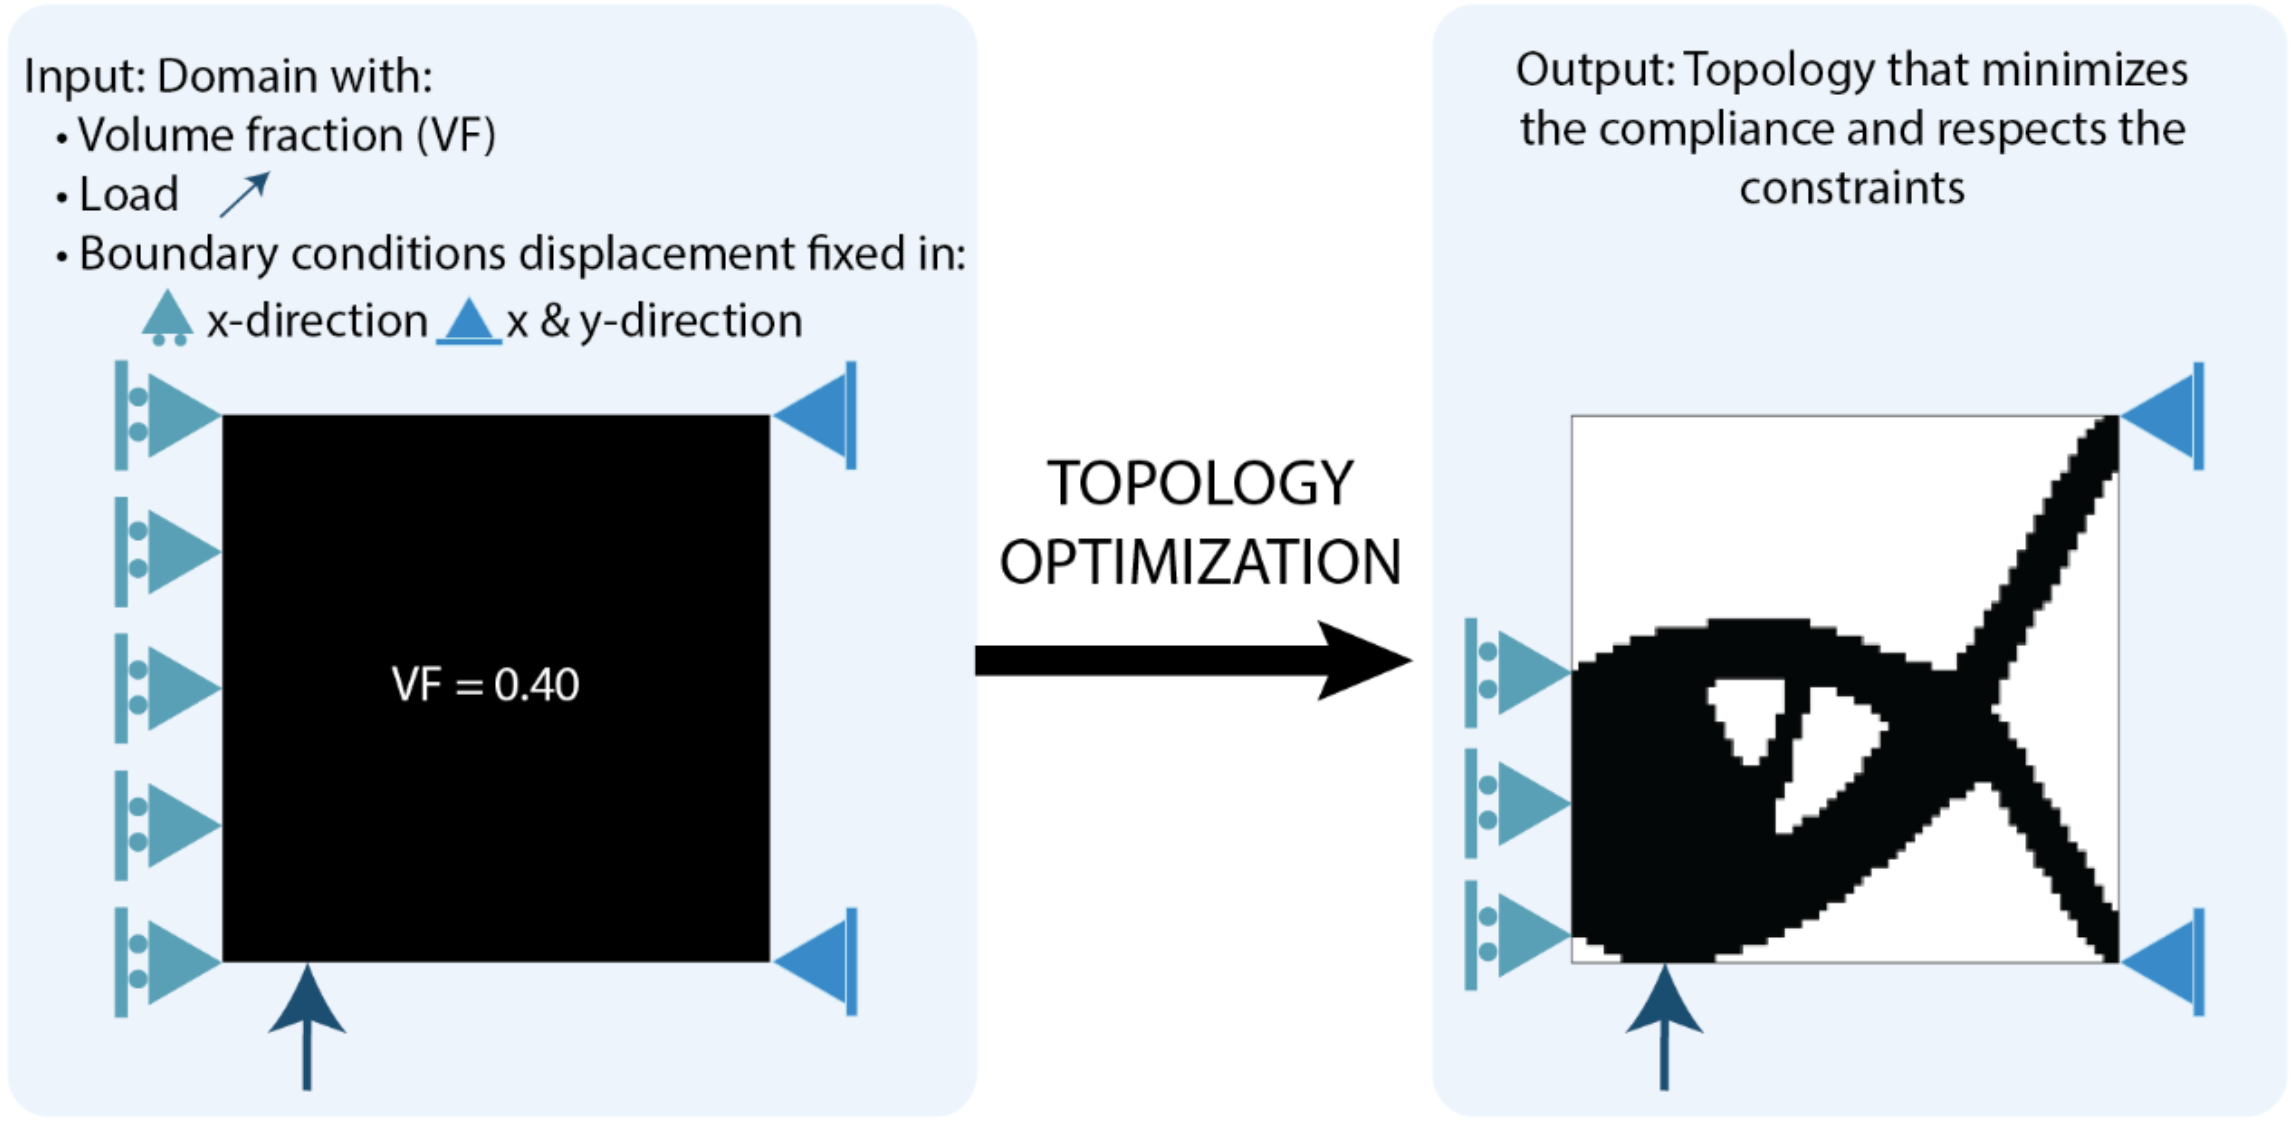

source: "Diffusion Models Beat GANs on Topology Optimization," Maze & Ahmed, 2023

### **The Task**
In this challenge problem, we task you with reconstructing corrupted topologies for which portions of the structure have been deleted.

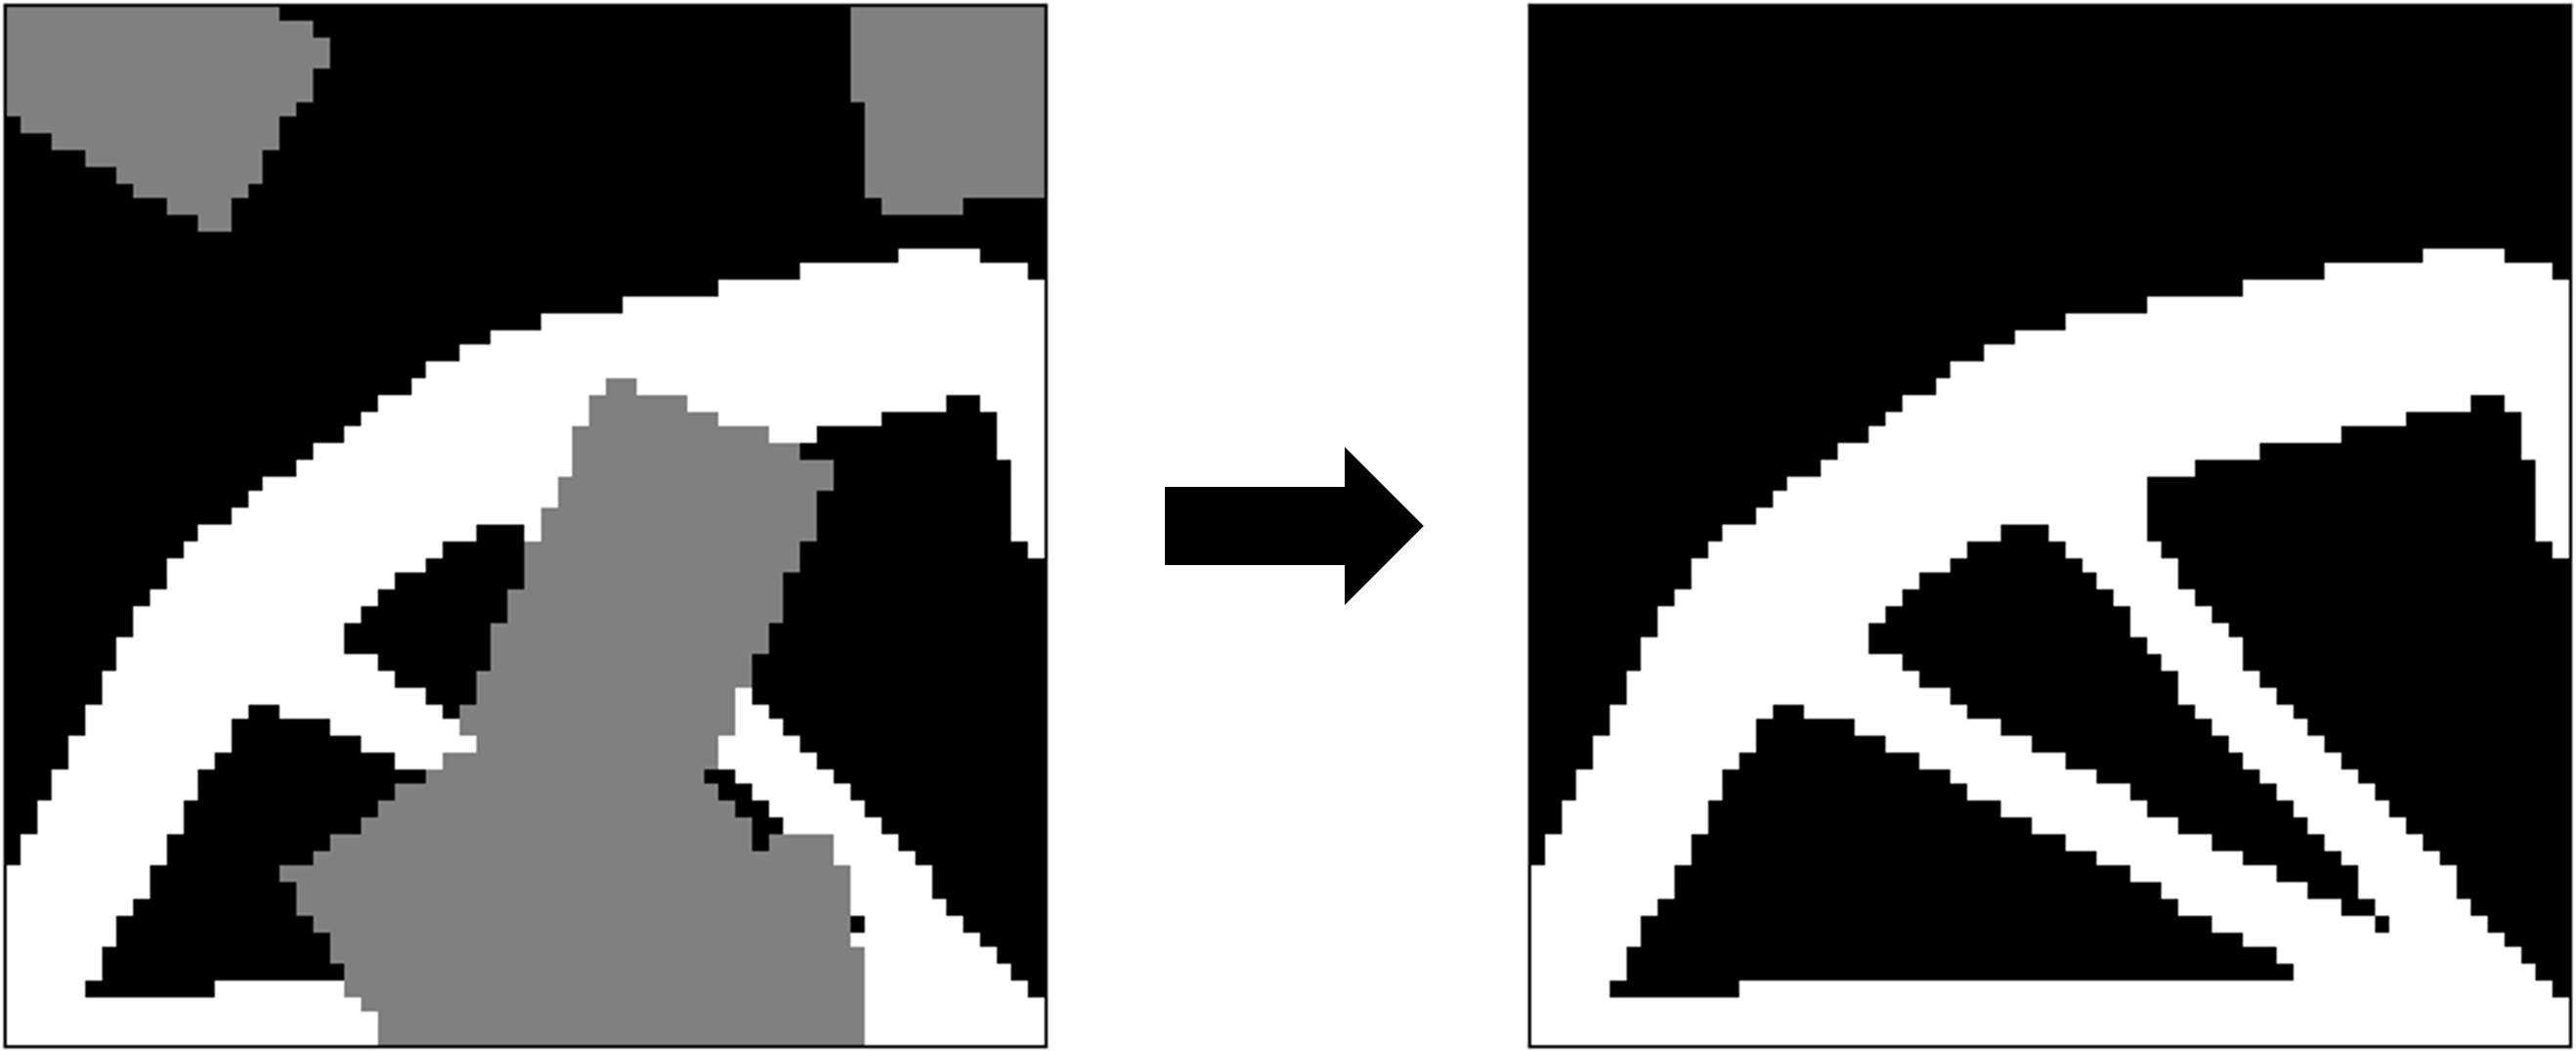


For the sake of this challenge problem, we will pretend that a malicious hacker has corrupted part of you dataset and you are trying to restore the data to its previous state as faithfully as possible. However, As discussed in lecture, reconstructing masked portions of a dataset has powerful practical purposes. For example, it can be a powerful method to train self-supervised learners. Masking is often used for inpainting tasks, and can be an viable method for human-AI collaboration (Say, if you wanted to remake a portion of a topology based on a new constraint constraint or even an aesthetic preference).

**The Dataset:**

We provide a dataset of 12,000 (uncorrupted) 64x64 topologies optimized for compliance minimization under a variety of loads, support cases, and material budgets. In these problems, 5 types of conditioning information are given, over which the material placement has been optimized. We'll refer to these simply as the 'constraints.'


*   Horizontal boundary conditions
*   Vertical boundary conditions
*   Horizontal loads
*   Vertical loads
*   Volume fraction



Let's first load the topologies and check their shape:

In [2]:
topologies = np.load("topologies_train.npy")
print(topologies.shape)

(12000, 64, 64)


Let's plot some of the topologies from the dataset:

<Figure size 640x480 with 0 Axes>

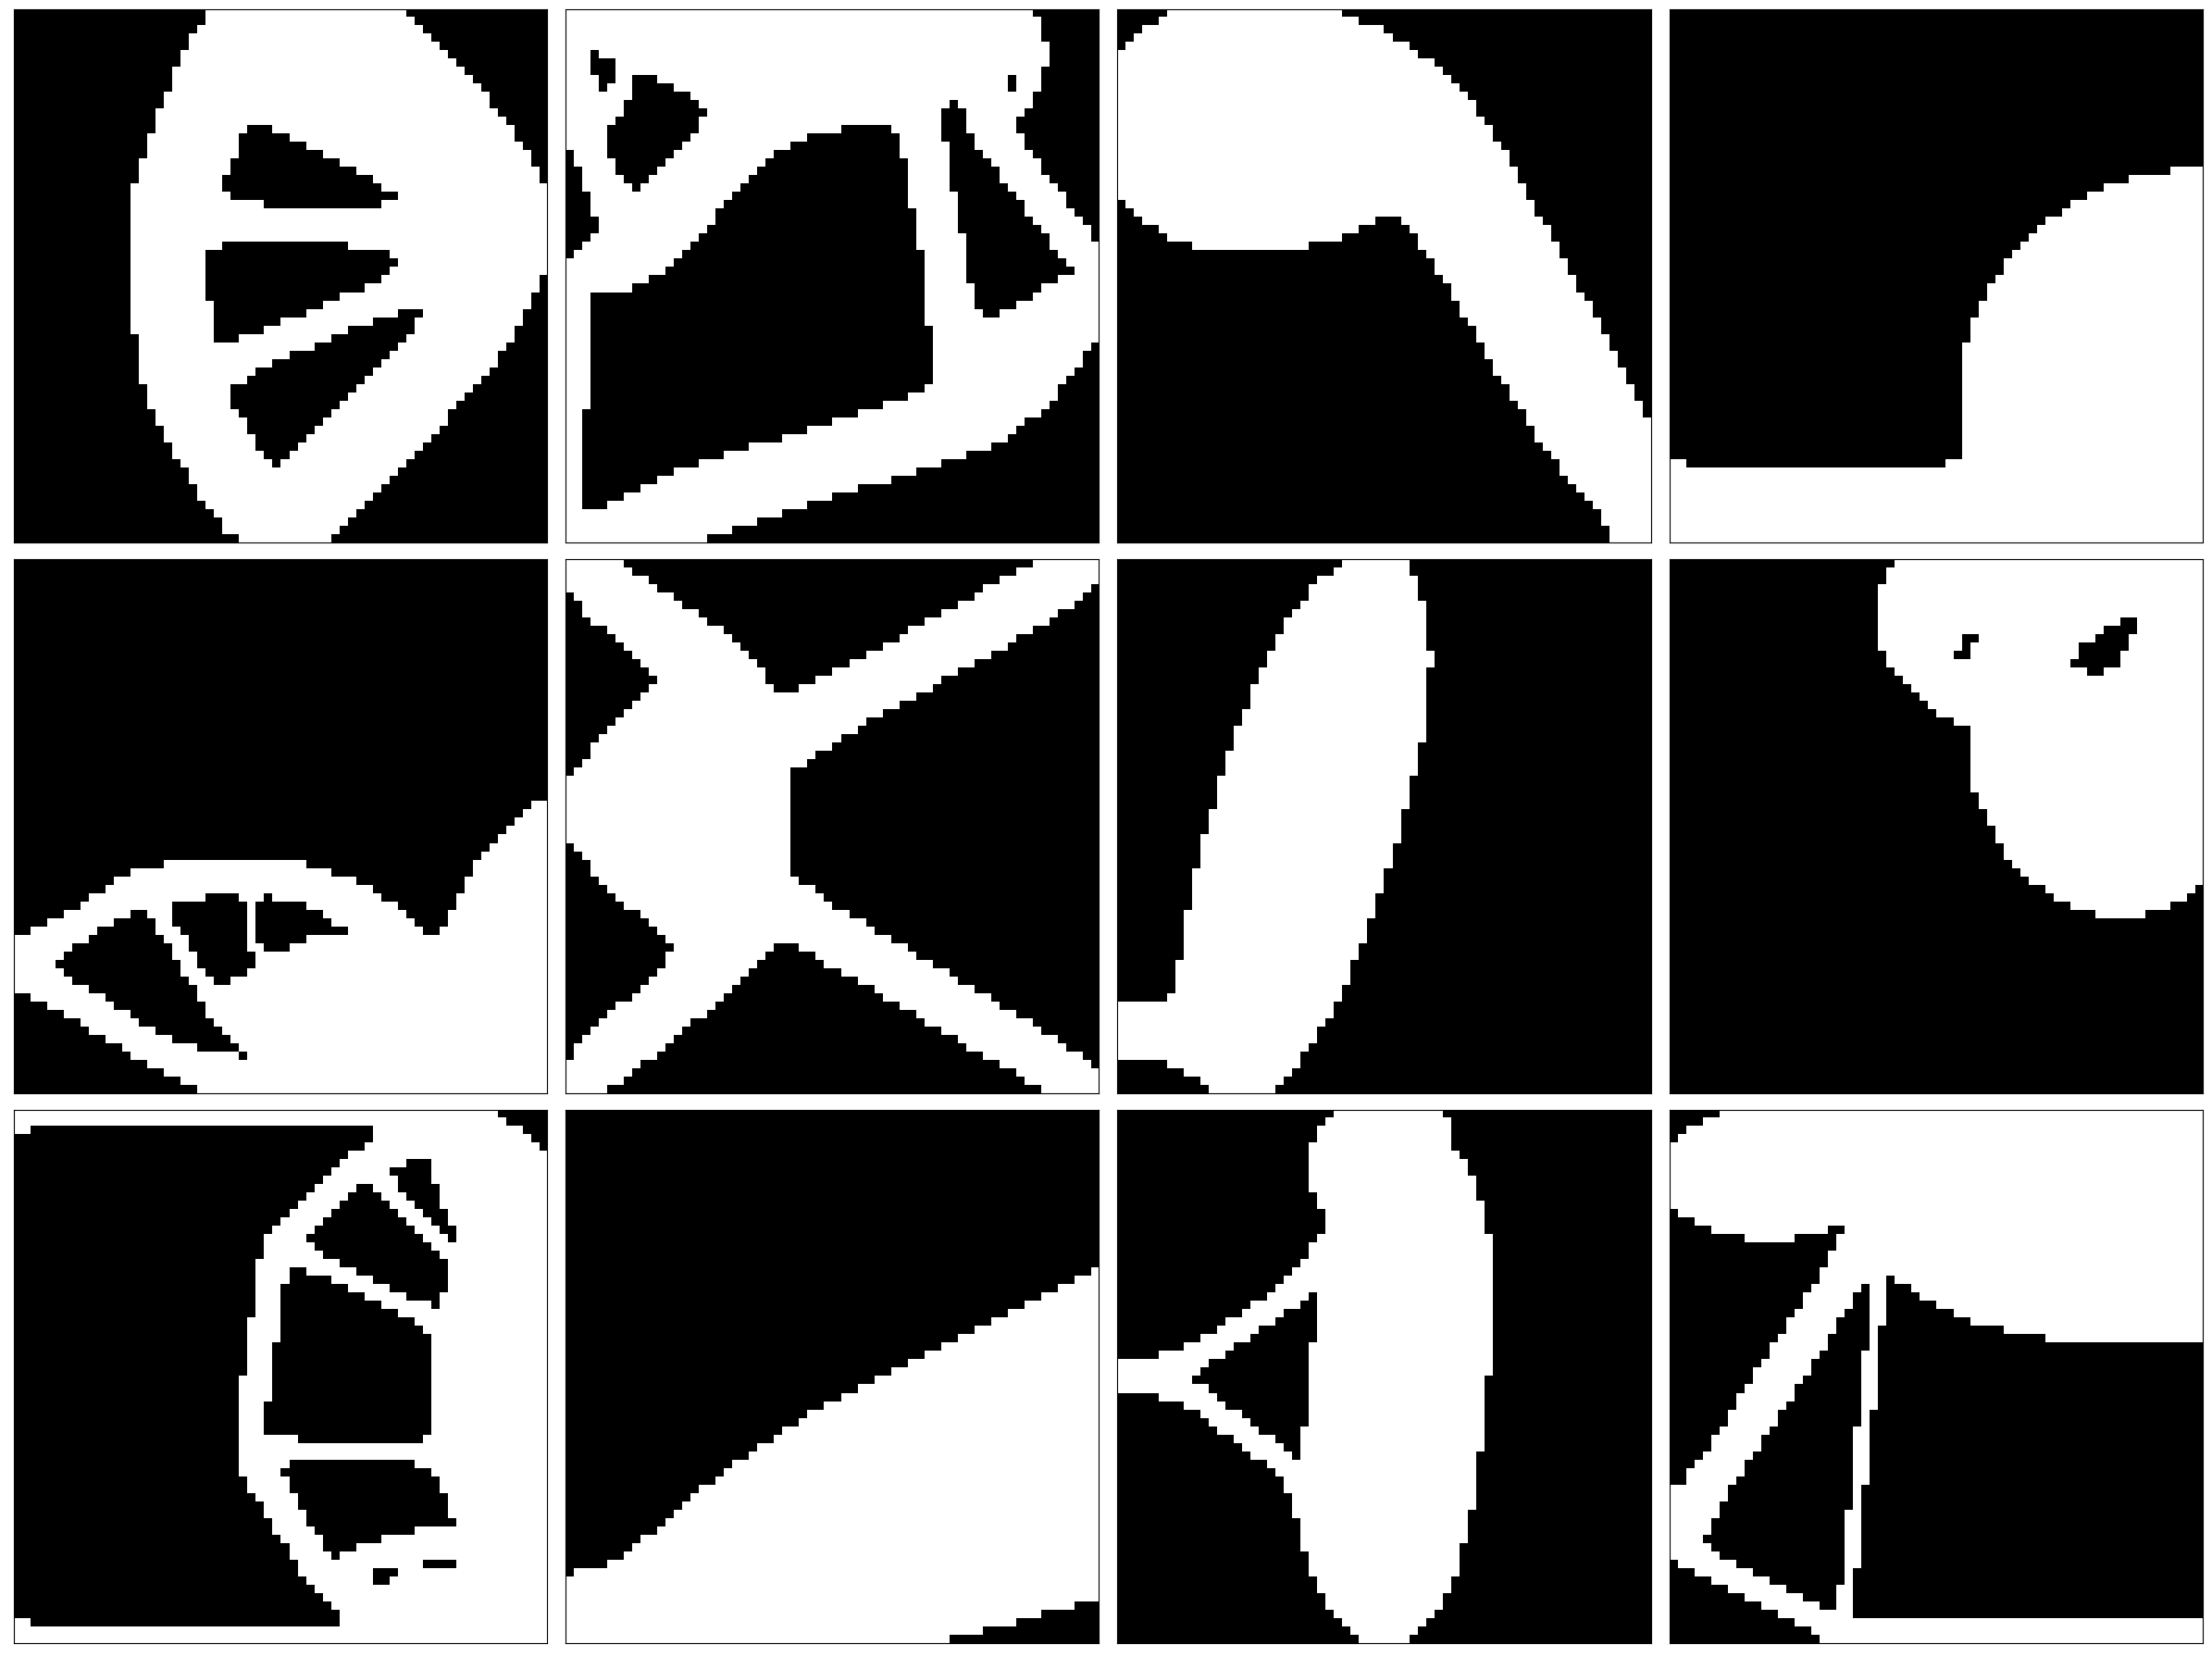

In [3]:
random_indices = np.random.choice(range(len(topologies)), 12)
plot_n_topologies(topologies[random_indices])

Now lets take a look at the constraints that was used to generate these topologies.

In [4]:
constraints = np.load("constraints_train.npy", allow_pickle=True)
print(len(constraints))
constraints[0]

12000


array([<64x64 sparse matrix of type '<class 'numpy.float64'>'
       	with 68 stored elements in Compressed Sparse Row format>,
       <64x64 sparse matrix of type '<class 'numpy.float64'>'
       	with 70 stored elements in Compressed Sparse Row format>,
       <64x64 sparse matrix of type '<class 'numpy.float64'>'
       	with 1 stored elements in Compressed Sparse Row format>,
       <64x64 sparse matrix of type '<class 'numpy.float64'>'
       	with 1 stored elements in Compressed Sparse Row format>,
       0.46000000000000013], dtype=object)

The constraints are given as a list of numpy arrays (in the same order as the topologies). The arrays each have five elements:

*   Horizontal boundary conditions (2D sparse matrix)
*   Vertical boundary conditions (2D sparse matrix)
*   Horizontal loads (2D sparse matrix)
*   Vertical loads (2D sparse matrix)
*   Volume fraction (float)

Let's take a look at the horizontal boundary conditions for the first topology in the dataset


In [5]:
print(constraints[0][0])

  (0, 0)	1.0
  (0, 63)	1.0
  (1, 0)	1.0
  (1, 63)	1.0
  (2, 63)	1.0
  (3, 63)	1.0
  (4, 63)	1.0
  (5, 63)	1.0
  (6, 63)	1.0
  (7, 63)	1.0
  (8, 63)	1.0
  (9, 63)	1.0
  (10, 63)	1.0
  (11, 63)	1.0
  (12, 63)	1.0
  (13, 63)	1.0
  (14, 63)	1.0
  (15, 63)	1.0
  (16, 63)	1.0
  (17, 63)	1.0
  (18, 63)	1.0
  (19, 63)	1.0
  (20, 63)	1.0
  (21, 63)	1.0
  (22, 63)	1.0
  :	:
  (41, 63)	1.0
  (42, 63)	1.0
  (43, 63)	1.0
  (44, 63)	1.0
  (45, 63)	1.0
  (46, 63)	1.0
  (47, 63)	1.0
  (48, 63)	1.0
  (49, 63)	1.0
  (50, 63)	1.0
  (51, 63)	1.0
  (52, 63)	1.0
  (53, 63)	1.0
  (54, 63)	1.0
  (55, 63)	1.0
  (56, 63)	1.0
  (57, 63)	1.0
  (58, 63)	1.0
  (59, 63)	1.0
  (60, 63)	1.0
  (61, 63)	1.0
  (62, 0)	1.0
  (62, 63)	1.0
  (63, 0)	1.0
  (63, 63)	1.0


We can convert these sparse matrices to numpy arrays. Let's do so and visualize.

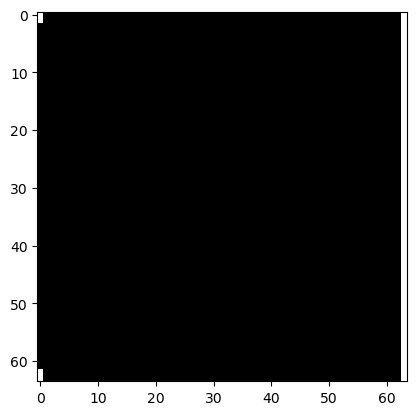

In [6]:
plt.imshow(constraints[0][0].toarray(), cmap="gray")

**Masking Functions:**

As discussed, we will be asking you to reconstruct topologies that have been partially masked. We have provided the EXACT masking function that we have used to generate the test set and the submission set. Note that this function is randomized. Let's take a look at some random masks and apply them to the sample topologies shown above.

In [7]:
masked_topologies = []
for i in trange(len(topologies)):
    mask = random_n_masks(np.array((64,64)), 4, 7).astype(bool)
    topology = topologies[i]
    masked_topology = topology*(1-mask) + 0.5*(mask)
    masked_topologies.append(masked_topology)
masked_topologies = np.stack(masked_topologies)


  0%|          | 33/12000 [00:00<00:36, 326.27it/s]

100%|██████████| 12000/12000 [00:39<00:00, 307.49it/s]


New, let's take a look at what these topologies look like after we have applied a mask. The masked areas are shown in gray:

<Figure size 640x480 with 0 Axes>

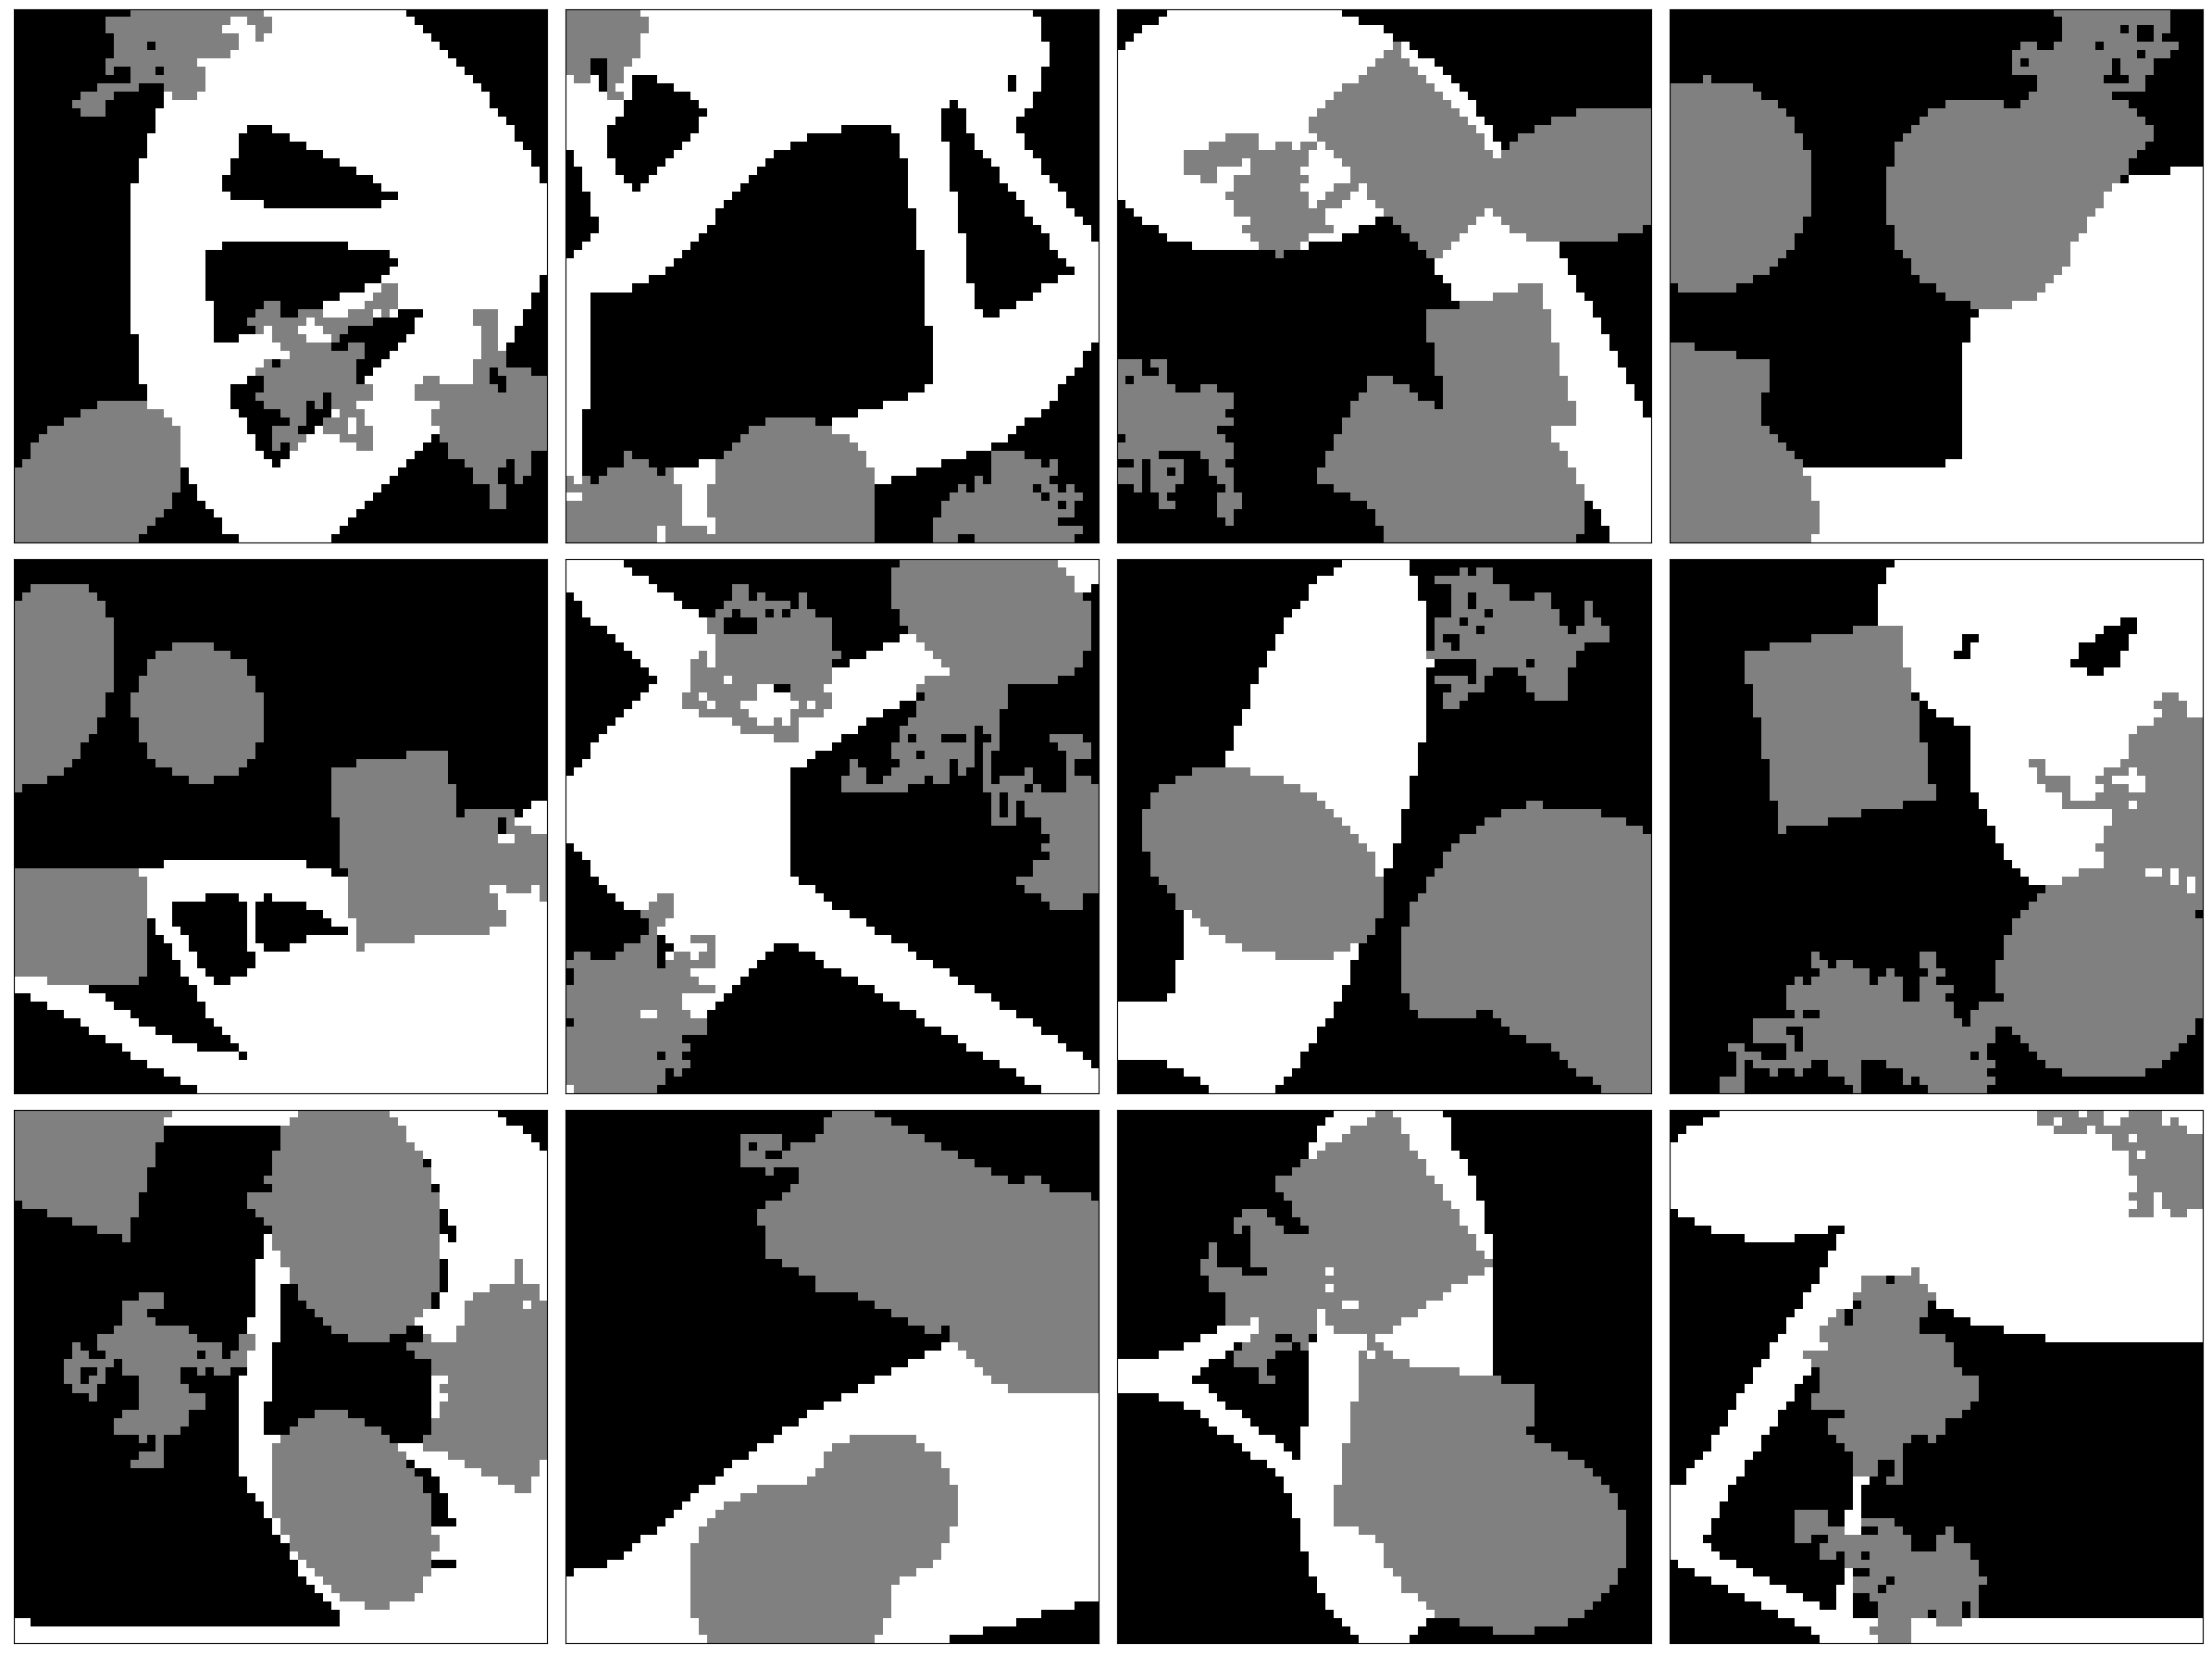

In [8]:
plot_n_topologies(masked_topologies[random_indices])

Constraints also get masked. For each topology, one of the five types of constraints (e.g. horizontal loads) will be converted to a Nonetype. Note: We do not base any scoring on reconstruction of masked constraints. However, doing so can help reconstruct topologies, which are scored.

Let's take a look at the constraint masking function:

In [9]:
masked_constraints = mask_constraints(constraints)
print(masked_constraints[0])

[<64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 68 stored elements in Compressed Sparse Row format> None
 <64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>
 <64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format> None]


### **Starter Code: VAE**
We have provided you some starter code in which we attempt to reconstruct the original topologies using a Variational Autoencoder (VAE). Below, we define the VAE model and a train loop function.

Note: This code does NOT make use of constraints.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class VAE(nn.Module): #Create VAE class inheriting from pytorch nn Module class
    def __init__(self, input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride):
        super(VAE, self).__init__()

        # Create encoder model
        self.encoder = Encoder(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride)

        #Create decoder after calculating input size for decoder
        decoder_input_size = self.calculate_decoder_input_size(image_size, num_layers, kernel_size, stride)
        self.decoder = Decoder(input_channels, hidden_size, num_layers, latent_dim, decoder_input_size, kernel_size, stride, image_size)

    def calculate_decoder_input_size(self, image_size, num_layers, kernel_size, stride):
        #Function to calculate the input size of the decoder given its architecture
        h, w = image_size
        for _ in range(num_layers):
            h = (h - kernel_size) // stride + 1
            w = (w - kernel_size) // stride + 1
        return h, w

    def reparameterize(self, mu, logvar):
        #Sample from gaussian
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_in):
        #Pass through encoder, reparameterize using mu and logvar as given by the encoder, then pass through decoder
        mu, logvar = self.encoder(x_in)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

class Encoder(nn.Module): #Encoder model of VAE
    def __init__(self, input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride):
        super(Encoder, self).__init__()

        layers = []
        h, w = image_size
        in_channels = input_channels
        for _ in range(num_layers): # Loop over layers, adding conv2d, layernorm, and relu.
            h = (h - kernel_size) // stride + 1 #Update h and w to compensate for previous layers output
            w = (w - kernel_size) // stride + 1
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, hidden_size, kernel_size, stride),
                    nn.LayerNorm([hidden_size, h, w]),
                    nn.ReLU()
                )
            )
            in_channels = hidden_size #Input channels to later conv layers will just be the hidden size

        self.conv_layers = nn.ModuleList(layers) #Collect convolution layers and layernorm in conv_layers object
        self.final_flatten_size = h * w * hidden_size #Calculate size of final FC output layer
        self.fc_mu = nn.Linear(self.final_flatten_size, latent_dim) #Final FC layer to output mean
        self.fc_logvar = nn.Linear(self.final_flatten_size, latent_dim) #Final FC layer to output logvar

    def forward(self, x): #Forward call for encoder
        for layer in self.conv_layers: #Call conv layers sequentially
            x = layer(x)
        x = x.view(x.size(0), -1) #Flatten x
        mu = self.fc_mu(x) #Get mu and logvar from FC layers
        logvar = self.fc_logvar(x)
        return mu, logvar #Return mu and logvar

class Decoder(nn.Module):  #Decoder model of VAE
    def __init__(self, output_channels, hidden_size, num_layers, latent_dim, decoder_input_size, kernel_size, stride, image_size):
        super(Decoder, self).__init__()
        self.decoder_input_size = decoder_input_size
        self.hidden_size = hidden_size

        #Initial fully connected layer
        self.fc = nn.Linear(latent_dim, hidden_size * decoder_input_size[0] * decoder_input_size[1])
        layers = []
        h, w = decoder_input_size
        for layer_num in range(num_layers-1): # Loop over layers, adding conv2dtranspose, layernorm, and relu.
            next_h, next_w = self.calc_size_layer(layer_num, num_layers, kernel_size, stride, image_size) #Calculate the size of the output of the layer
            output_padding_h = next_h - kernel_size - stride*(h-1) #Calculate the output padding to ensure the output size is correct
            output_padding_w = next_w - kernel_size - stride*(w-1)
            layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size, stride),
                    nn.ReplicationPad2d((0,output_padding_w,0, output_padding_h)),
                    nn.LayerNorm([hidden_size, next_h, next_w]),
                    nn.ReLU()
                )
            )
            h,w = next_h, next_w

        self.deconv_layers = nn.ModuleList(layers) #Collect deconv layers

        next_h, next_w = image_size

        output_padding_h = next_h - kernel_size - stride*(h-1) #Calculate the output padding to ensure the output size is correct
        output_padding_w = next_w - kernel_size - stride*(w-1)
        #Final layer brings the image to the original size
        self.final_layer = nn.Sequential(nn.ConvTranspose2d(hidden_size, output_channels, kernel_size, stride),
                                        nn.ReplicationPad2d((0,output_padding_w,0, output_padding_h)))
    def calc_size_layer(self, layer_num, num_layers, kernel_size, stride, image_size):
        #Function to calculate the number of channels for a given layer
        h, w = image_size
        for _ in range(num_layers-layer_num-1):
            h = (h - kernel_size) // stride + 1
            w = (w - kernel_size) // stride + 1
        return h,w


    def forward(self, z):
        z = self.fc(z) #Call initial FC layer
        z = z.view(z.size(0), self.hidden_size, self.decoder_input_size[0], self.decoder_input_size[1])  # Reshape to match the deconvolution input shape
        for layer in self.deconv_layers: #Sequentially call deconv layers
            z = layer(z)
        z = self.final_layer(z)
        return torch.sigmoid(z) #Final sigmoid layer

def loss_function(recon_x, x_out, mu, logvar):
    # VAE loss is a sum of KL Divergence regularizing the latent space and reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x_out, reduction='sum') # Reconstruction loss from Binary Cross Entropy
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #KL Divergence loss
    return BCE + KLD

def train(epoch, data_in_tensor, data_out_tensor): #Train function for one epoch of training
    model.train()
    train_loss = 0
    num_batches = len(data_in_tensor) // batch_size

    #Tqdm progress bar object contains a list of the batch indices to train over
    progress_bar = tqdm(range(num_batches), desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)

    for batch_idx in progress_bar: #Loop over batch indices
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        data_in = data_in_tensor[start_idx:end_idx] #Gather corresponding data
        data_out = data_out_tensor[start_idx:end_idx] #Gather corresponding data


        optimizer.zero_grad() #Set up optimizer
        recon_batch, mu, logvar = model(data_in) #Call model
        loss = loss_function(recon_batch, data_out, mu, logvar) #Call loss function
        loss.backward() #Get gradients of loss
        train_loss += loss.item() #Append to total loss
        optimizer.step() #Update weights using optimizeer

        # Updating the progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

    average_train_loss = train_loss / len(data_in_tensor) #Calculate average train loss
    tqdm.write('Epoch: {} \tTraining Loss: {:.3f}'.format(epoch, average_train_loss))

/Users/zihaofoo/miniconda3/envs/python3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We prepare the training data:

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Check if gpu/tpu is available

data_in_tensor = torch.from_numpy(masked_topologies).float().to(device)
data_out_tensor = torch.from_numpy(topologies).float().to(device)

#expand dims of tensor in channel 1
data_in_tensor = data_in_tensor.unsqueeze(1)
data_out_tensor = data_out_tensor.unsqueeze(1)

Set up some hyperparameters:

In [12]:
input_channels = 1
image_size = (64, 64)

latent_dim = 10
hidden_size = 64
num_layers = 3
kernel_size = 3
stride = 2
num_epochs = 20
batch_size = 64

model = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#Let's look at a model summary
from torchsummary import summary
print((input_channels, image_size[0], image_size[1]))
summary(model, input_size=(input_channels, image_size[0], image_size[1]))

(1, 64, 64)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]             640
         LayerNorm-2           [-1, 64, 31, 31]         123,008
              ReLU-3           [-1, 64, 31, 31]               0
            Conv2d-4           [-1, 64, 15, 15]          36,928
         LayerNorm-5           [-1, 64, 15, 15]          28,800
              ReLU-6           [-1, 64, 15, 15]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
         LayerNorm-8             [-1, 64, 7, 7]           6,272
              ReLU-9             [-1, 64, 7, 7]               0
           Linear-10                   [-1, 10]          31,370
           Linear-11                   [-1, 10]          31,370
          Encoder-12       [[-1, 10], [-1, 10]]               0
           Linear-13                 [-1, 3136]          34,496
  ConvTranspose2d-14       

In [13]:
# Main loop
for epoch in range(1, num_epochs + 1):
    train(epoch, data_in_tensor, data_out_tensor)

Epoch: 1 	Training Loss: 1647.442


Epoch: 2 	Training Loss: 1216.778


Epoch 003:  93%|█████████▎| 174/187 [01:18<00:08,  1.49it/s, training_loss=75798.164]

In [ ]:
def reconstruct_from_vae(model, masked_topologies, device='cpu'):
    with torch.no_grad():
        data_in = torch.from_numpy(masked_topologies).float()
        data_in = data_in.unsqueeze(1).to(device)
        samples = model(data_in)[0][:,0,:,:].to('cpu').numpy()
        samples = np.round(samples)
    return samples

def plot_reconstruction(originals, masked, reconstructions):
    # Function to plot reconstructed city grids alongside originals
    n = len(originals)
    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(9, 2*n))
    for i in range(n): # Loop over the grids
        axes[i,0].imshow(masked[i], cmap = "gray") # Plot masked on the left
        axes[i,1].imshow(reconstructions[i], cmap = "gray") # Plot reconstruction on the left
        axes[i,2].imshow(originals[i], cmap = "gray") #Plot originals on the right
        axes[i,3].imshow(originals[i]-reconstructions[i], cmap = "RdBu") #Plot error on the right
    fig.tight_layout()
    plt.show()

originals = np.random.choice(np.arange(len(masked_topologies)), size=5, replace=False) #Select 5 random indices
reconstructions = reconstruct_from_vae(model, masked_topologies[originals], device) #Reconstruct
plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions) #Compare

: 

**Testing:**

Great! Now, it's time to test our model's performance. In this challenge problem we have provided a **test set** of masked topologies as well as their unmasked counterparts (as well as masked and unmasked constraints - if you choose to use them). The goal of this test set if for you to have an unbiased metric for the performance of you model. Test set scores will also be self-reported to the leaderboard. Please try to keep our leaderboard accurate - Do not bias your model by training on the test set or even tuning hyperparameters on the test set (this is what validation is for).

Though we know you are all honest, we want to ensure there is no accidental overfitting. As such, we will ask you to submit final predictions on a **submission set.** There is no systematic difference between the submission set and the test set (or the train set, for that matter). However, we will only provide the masked topologies and constraints on the submission set and not the ground truth. When you submit your report, please submit final predictions on the submission set, not the test set.

Ok, let's evaluate on the test set. We load up the masked topologies and the ground truth topologies of the test set. We pass the masked topologies into our VAE for predictions.

In [ ]:
topologies_test = np.load("topologies_test.npy")
masked_topologies_test = np.load("masked_topologies_test.npy")
reconstructions_test = reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct

: 

**Scoring Function:**

Here is the evaluation function that we will be using: We simply calculate the fraction of pixels predicted accurately within the masked proportion of the topology. This is essentially the classic "accuracy" score in a binary classification problem - calculated over all pixels in the mask. We then average the accuracy values over all topologies.

In [ ]:
def evaluate_score(masked_topologies, original_topologies, reconstructed_topologies):
    masks = masked_topologies==0.5 #Identify the masked regions
    correct = reconstructed_topologies==original_topologies #Identify all correctly predicted pixels
    correct_in_mask = np.logical_and(correct, masks) # Identify all correctly predicted pixels within masked regions
    accuracy_fractions = np.sum(correct_in_mask, axis=(1,2))/np.sum(masks, axis=(1,2)) #(correct & mask)/#(mask) for each topology individually
    average_accuracy_fraction = np.mean(accuracy_fractions) #Average of these ratios across test set
    return average_accuracy_fraction
score = evaluate_score(masked_topologies_test, topologies_test, reconstructions_test)
print(f"Final Accuracy: {score:.5f}")

: 

**Preparing a Submission**

Preparing a submission is simple: We first load the masked topologies. We can visualize some to verify that all is in order.

In [ ]:
masked_topologies_submission = np.load("masked_topologies_submission.npy")
random_indices = np.random.choice(range(len(masked_topologies_submission)), 2)
plot_n_topologies(masked_topologies_submission[random_indices])



: 

We pass them into our model to reconstruct (replace with your implementation here). We then binarize:

In [ ]:
reconstructions_submission = reconstruct_from_vae(model, masked_topologies_submission, device) #Reconstruct
reconstructions_submission = np.round(reconstructions_submission).astype(bool)

: 

We can visualize the reconstructions to double everything looks right:

In [ ]:
plot_n_topologies(reconstructions_submission[random_indices])

: 

Assert everything is in the right shape:

In [ ]:
assert reconstructions_submission.shape == (1200,64,64)
assert reconstructions_submission.dtype == bool

: 

And we save our numpy array. Remember to download it if you run in colab.

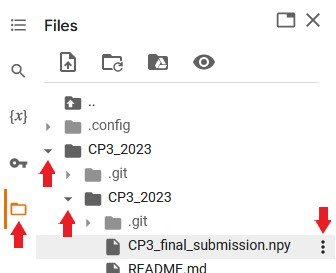

In [ ]:
np.save("CP3_final_submission.npy", reconstructions_submission)

: 

**THIS IS A FINAL REMINDER NOT TO SUBMIT THE TEST SET PREDICTIONS AS YOUR FINAL SUBMISSION**

**Some Notes:**

As with previous challenge problems, you can use whatever resources you like. These include, but are not limited to: Pretrained models, outside datasets, chatGPT, manual labeling (please don't tho), etc.

Some random links/references that are relevant:

https://openaccess.thecvf.com/content_cvpr_2018/papers/Yu_Generative_Image_Inpainting_CVPR_2018_paper.pdf

https://arxiv.org/pdf/1611.07004.pdf

https://arxiv.org/pdf/2208.09591.pdf

https://arxiv.org/pdf/2003.04685.pdf




: 